In [1]:
!pip install -r requirements.txt

  Cloning https://github.com/marco-willi/cas-dl-compvis-exercises-hs2024 (to revision dd810a944f66038ec2e778f69fa38a0d0e780ff8) to /private/var/folders/wk/k5zyv86x5v7dpc77gzc5vx6r0000gn/T/pip-install-7wjau5bz/dl-cv-lectures_a649974cfe904276ba384779b22a53ee
  Running command git clone --filter=blob:none --quiet https://github.com/marco-willi/cas-dl-compvis-exercises-hs2024 /private/var/folders/wk/k5zyv86x5v7dpc77gzc5vx6r0000gn/T/pip-install-7wjau5bz/dl-cv-lectures_a649974cfe904276ba384779b22a53ee
  Git user:  <>
  Running command git rev-parse -q --verify 'sha^dd810a944f66038ec2e778f69fa38a0d0e780ff8'
  Running command git fetch -q https://github.com/marco-willi/cas-dl-compvis-exercises-hs2024 dd810a944f66038ec2e778f69fa38a0d0e780ff8
  Resolved https://github.com/marco-willi/cas-dl-compvis-exercises-hs2024 to commit dd810a944f66038ec2e778f69fa38a0d0e780ff8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... do

In [32]:
import torch
import torch.nn as nn
import torchinfo
from lightning.pytorch.loggers import TensorBoardLogger
from torchvision import transforms
from torchvision.transforms.v2 import functional as TF
from utils import DataSetModule
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

In [33]:
import torchmetrics
import torchvision.models as models
import lightning as L
from ray.air import ScalingConfig, RunConfig, CheckpointConfig
from ray.train.huggingface.transformers import prepare_trainer
from ray.train.lightgbm import RayTrainReportCallback
from ray.train.lightning import RayDDPStrategy, RayLightningEnvironment
from ray.train.torch import TorchTrainer
from ray.tune import choice, loguniform, Tuner, TuneConfig
from ray.tune.schedulers import ASHAScheduler

In [34]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [35]:
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False

print(f"In colab: {IN_COLAB}")

In colab: False


In [36]:
if IN_COLAB:
    from google.colab import drive

    drive.mount("/content/drive")

In [37]:
import os
from pathlib import Path
from utils import ImageFolder, create_train_test_split


if IN_COLAB:
    pass  # TODO DATA_PATH = Path("/content/drive/MyDrive/cas-dl-module-compvis-part1")
    raise RuntimeError
else:
    SCRIPT_DIR = Path(os.getcwd())

In [38]:
DATA_BASE_PATH = SCRIPT_DIR / "data" / "data_set"

DATA_PATHS = [DATA_BASE_PATH / "photos", DATA_BASE_PATH / "renders"]
 #data_paths = SCRIPT_DIR / "data" / "data_set" / "three_classes"

# Data

In [39]:
ds = ImageFolder(DATA_PATHS)
num_classes = len(ds.classes)

File /Users/lukaswoodtli/Meine Ablage/fhnw_computer_vision_mit_deep_learning_projekt/data/data_set/photos/93273/c2_5_27z3_original_93273_1609896224186.jpg could not be opened
Found the following classes: ['20896', '2454', '3062', '3068', '3245', '35336_4176', '3957', '6014', '64288', '98197', 'Bar 1 x 4 x 2 with Studs', 'Bar 1 x 8 x 2', 'Bar 1L with Clip [Cut Edges and One Side Hole] [Gap in Clip]', 'Bar 2L with Towball', 'Bar 7 x 3 with Double Clips (Ladder) [Straight Clips]', 'Bar Holder with Clip', 'Bracket 1 x 1 - 1 x 1', 'Bracket 1 x 1 - 1 x 1 Inverted', 'Bracket 1 x 2 - 1 x 2', 'Bracket 1 x 2 - 1 x 2 Inverted', 'Bracket 1 x 2 - 1 x 4 [Rounded Corners]', 'Bracket 1 x 2 - 2 x 2', 'Bracket 1 x 2 - 2 x 2 Inverted', 'Bracket 1 x 2 - 2 x 4', 'Bracket 2 x 2 with 1 x 2 Vertical Studs', 'Bracket 5 x 2 x 1 1/3 with Holes, Pin Bottom', 'Brick 1 x 1', 'Brick 1 x 1 x 3', 'Brick 1 x 1 x 5 with Solid Stud', 'Brick 1 x 10', 'Brick 1 x 2', 'Brick 1 x 3', 'Brick 1 x 4', 'Brick 1 x 6', 'Brick 1 x 8

448

In [ ]:
num_classes, len(ds)

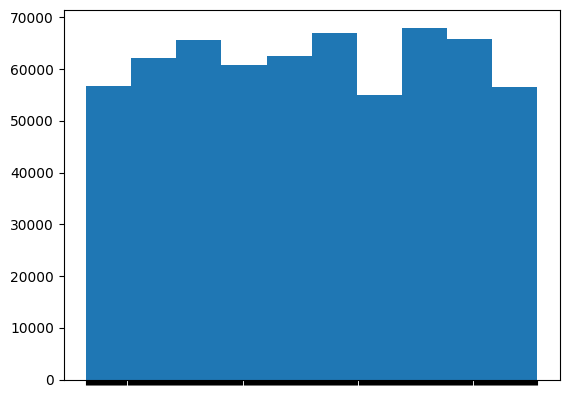

In [43]:
from utils import labels_hist

labels_hist(ds.observations)

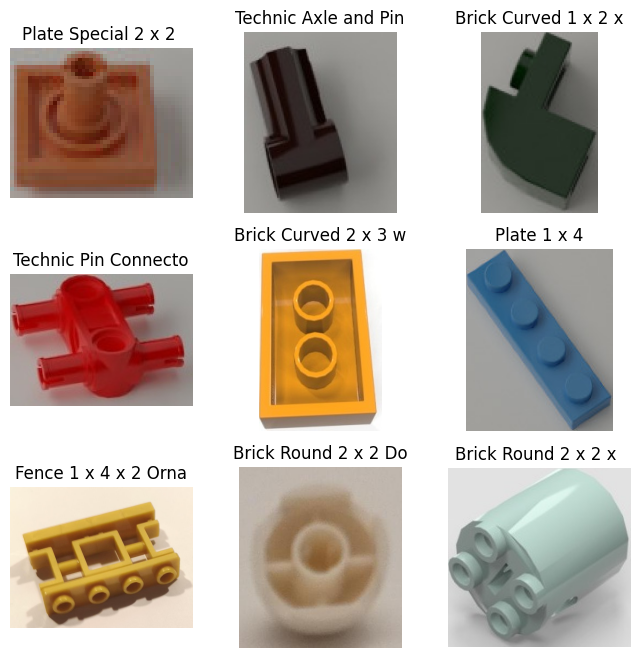

In [55]:
from utils import plot_random_image_grid

plot_random_image_grid(ds)

# Data Loader

In [57]:
def load_data(ds, tr_train, tr_val, batch_size=64):
    all_ids = [i for i in range(0, len(ds.observations))]
    all_labels = [x["label"] for x in ds.observations]

    train_ids, val_ids, test_ids = create_train_test_split(
        all_ids, all_labels, random_state=123, test_size=0.2, val_size=0.1
    )


    ds_train = ImageFolder.from_subset(ds, train_ids)
    ds_val = ImageFolder.from_subset(ds, val_ids)
    ds_test = ImageFolder.from_subset(ds, test_ids)

    dm = DataSetModule(
        ds_train=ds_train,
        ds_val=ds_val,
        ds_test=ds_test,
        classes=ds.classes,
        train_transform=tr_train,
        test_transform=tr_val,
        batch_size=batch_size,
    )
    return dm

# Models

In [3]:
def get_resnet18_model_and_transforms(num_classes, additional_train_transforms=None):
    net = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    net.fc = nn.Sequential(nn.Linear(512, num_classes))

    common_transforms = transforms.Compose(
        [
            transforms.v2.RGB(),
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )

    if additional_train_transforms is not None:
        tr_train = transforms.Compose(
            [
                additional_train_transforms,
                common_transforms,
            ]
        )
    else:
        tr_train = common_transforms

    tr_val = common_transforms


    return net, tr_train, tr_val


def get_resnext101_model_and_transforms(num_classes, additional_train_transforms=None):
    net = models.resnext101_64x4d(weights=models.ResNeXt101_64X4D_Weights.DEFAULT)
    net.fc = nn.Sequential(nn.Linear(2048, num_classes))

    common_transforms = transforms.Compose([
            transforms.RandomResizedCrop(128),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    if additional_train_transforms is not None:
        tr_train = transforms.Compose(
            additional_train_transforms,
            common_transforms
        )
    else:
        tr_train = common_transforms

    tr_val = common_transforms

    return net, tr_train, tr_val


# Classifier

In [59]:
class Classifier(L.LightningModule):
    def __init__(self, model, num_classes=2, learning_rate=0.001, weight_decay: float = 0.0):
        super().__init__()
        self.model = model

        self.learning_rate = learning_rate
        self.weight_decay = weight_decay

        self.loss_fn = nn.CrossEntropyLoss()

        # Accuracy
        self.train_accuracy = torchmetrics.Accuracy(
            task="multiclass", num_classes=num_classes
        )
        self.val_accuracy = torchmetrics.Accuracy(
            task="multiclass", num_classes=num_classes
        )

        # Loss
        self.train_loss = torchmetrics.MeanMetric()
        self.val_loss = torchmetrics.MeanMetric()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch["image"], batch["label"]
        logits = self.model(x)
        loss = self.loss_fn(logits, y)
        preds = torch.argmax(logits, dim=1)

        # Update all metrics
        self.train_loss.update(loss)
        self.train_accuracy.update(preds, y)

        # Log metrics for bartch
        self.log("train/loss_step", loss, prog_bar=True, on_step=True, on_epoch=False)

        self.log(
            "train/acc_step",
            self.train_accuracy,
            prog_bar=True,
            on_step=True,
            on_epoch=False,
        )

        return loss

    def on_train_epoch_end(self):
        # Log average loss and metrics for the entire epoch
        avg_loss = self.train_loss.compute()
        avg_accuracy = self.train_accuracy.compute()

        self.log("train/loss_epoch", avg_loss, prog_bar=True, on_epoch=True)
        self.log("train/accuracy_epoch", avg_accuracy, prog_bar=True, on_epoch=True)

        # Reset metrics for the next epoch
        self.train_loss.reset()
        self.train_accuracy.reset()

    def validation_step(self, batch, batch_idx):
        x, y = batch["image"], batch["label"]
        logits = self.model(x)
        loss = self.loss_fn(logits, y)
        preds = torch.argmax(logits, dim=1)

        # Update metrics
        self.val_loss.update(loss)
        self.val_accuracy.update(preds, y)

        # Log metrics for this batch
        self.log("val/loss_step", loss, prog_bar=True, on_step=True, on_epoch=False)
        self.log(
            "val/accuracy_step",
            self.val_accuracy,
            prog_bar=True,
            on_step=True,
            on_epoch=False,
        )

        return loss

    def on_validation_epoch_end(self):
        # Log average loss and metrics for the entire validation epoch
        avg_loss = self.val_loss.compute()
        avg_accuracy = self.val_accuracy.compute()

        self.log("val/loss_epoch", avg_loss, prog_bar=True, on_epoch=True)
        self.log("val/accuracy_epoch", avg_accuracy, prog_bar=True, on_epoch=True)

        # Reset metrics for the next epoch
        self.val_loss.reset()
        self.val_accuracy.reset()

    def configure_optimizers(self):
        return torch.optim.Adam(
            self.parameters(), self.learning_rate, weight_decay=self.weight_decay
        )

# Training Loop

In [60]:
# early stopping callback
early_stopping = EarlyStopping(
    monitor="val/accuracy_epoch",
    min_delta=0.01,
    patience=5,
    mode="max",
    verbose=True,
    strict=True,
)

default_config = {
    "batch_size": 32,
    "learning_rate": 1e-3,
    "weight_decay": 1e-4,
}

def training_loop(config=default_config):

    L.seed_everything(123)
    logger = TensorBoardLogger(SCRIPT_DIR.joinpath("lightning_logs"), name="resnext101")

    trainer = L.Trainer(
        devices="auto",
        accelerator="auto",
        precision="32",
        strategy=RayDDPStrategy(),
        fast_dev_run=False,
        enable_checkpointing=False,
        logger=logger,
        log_every_n_steps=1,
        callbacks=[early_stopping, RayTrainReportCallback()],
        plugins=[RayLightningEnvironment()],
        default_root_dir=SCRIPT_DIR.joinpath("lightning_logs"),
    )
    trainer = prepare_trainer(trainer)

    ds = ImageFolder(DATA_PATHS)

    num_classes = len(ds.classes)

    net, tr_train, tr_val = get_resnext101_model_and_transforms(num_classes)
    print(torchinfo.summary(net, input_size=(1, 3, 64, 64)))

    dm = load_data(ds, tr_train, tr_val, config["batch_size"])

    model = Classifier(net, num_classes=num_classes,
                       learning_rate=config["learning_rate"],
                       weight_decay=config["weight_decay"])

    trainer.fit(model, datamodule=dm)


complex_transforms_0 = transforms.Compose(
    [
        transforms.RandomRotation(12),
        transforms.RandomResizedCrop(224),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    ])

complex_transforms_1 = transforms.Compose(
    [
        transforms.RandomRotation(10),
        transforms.RandomResizedCrop(224),
        transforms.RandomApply(
            [transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2)],
            p=0.8,
        ),
        transforms.RandomGrayscale(p=0.2),
    ])

search_space = {
    "additional_transforms": choice([None, complex_transforms_0, complex_transforms_1]),
    "learning_rate": loguniform(1e-4, 1e-1),
    "weight_decay": loguniform(1e-4, 1e-2),
    "batch_size": choice([32, 64]),
}


def tune():
    max_epochs = 20
    num_samples = 10

    scheduler = ASHAScheduler(max_t=max_epochs, grace_period=1, reduction_factor=2)

    scaling_config = ScalingConfig(
        num_workers=3, use_gpu=True, resources_per_worker={"CPU": 1, "GPU": 1}
    )

    run_config = RunConfig(
        checkpoint_config=CheckpointConfig(
            num_to_keep=2,
            checkpoint_score_attribute="val/accuracy_epoch",
            checkpoint_score_order="max",
        ),
    )

    ray_trainer = TorchTrainer(
        training_loop,
        scaling_config=scaling_config,
        run_config=run_config,
    )

    tuner = Tuner(
        ray_trainer,
        param_space={"train_loop_config": search_space},
        tune_config=TuneConfig(
            metric="val/accuracy_epoch",
            mode="max",
            num_samples=num_samples,
            scheduler=scheduler,
        ),
    )
    return tuner.fit()


(autoscaler +43m48s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(autoscaler +43m48s) Error: No available node types can fulfill resource request {'CPU': 2.0, 'GPU': 2.0}. Add suitable node types to this cluster to resolve this issue.
(autoscaler +43m48s) Error: No available node types can fulfill resource request {'CPU': 1.0, 'GPU': 2.0}. Add suitable node types to this cluster to resolve this issue.


(raylet) [2024-11-26 21:23:32,263 E 19164 2389576] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2024-11-26_21-23-21_294574_17683 is over 95% full, available space: 17.0974 GB; capacity: 926.352 GB. Object creation will fail if spilling is required.
(raylet) [2024-11-26 21:23:42,361 E 19164 2389576] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2024-11-26_21-23-21_294574_17683 is over 95% full, available space: 17.0974 GB; capacity: 926.352 GB. Object creation will fail if spilling is required.
2024-11-26 21:23:42,491	WARNING tune.py:219 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2024-11-26 21:23:42,499	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/Users/lukaswoodtli/ray_results/TorchTrainer_2024-11-26_21-23-21' in 0.0063s.
2024-11-26 21:23:42,511	INFO tune.py:1041 -- Total run t

ResultGrid<[
  Result(
    metrics={},
    path='/Users/lukaswoodtli/ray_results/TorchTrainer_2024-11-26_21-23-21/TorchTrainer_49418_00000_0_additional_transforms=None,batch_size=32,learning_rate=0.0001,weight_decay=0.0019_2024-11-26_21-23-23',
    filesystem='local',
    checkpoint=None
  ),
  Result(
    metrics={},
    path='/Users/lukaswoodtli/ray_results/TorchTrainer_2024-11-26_21-23-21/TorchTrainer_49418_00001_1_additional_transforms=ref_ph_6fe170f5,batch_size=32,learning_rate=0.0062,weight_decay=0.0069_2024-11-26_21-23-23',
    filesystem='local',
    checkpoint=None
  ),
  Result(
    metrics={},
    path='/Users/lukaswoodtli/ray_results/TorchTrainer_2024-11-26_21-23-21/TorchTrainer_49418_00002_2_additional_transforms=ref_ph_6fe170f5,batch_size=64,learning_rate=0.0025,weight_decay=0.0010_2024-11-26_21-23-23',
    filesystem='local',
    checkpoint=None
  ),
  Result(
    metrics={},
    path='/Users/lukaswoodtli/ray_results/TorchTrainer_2024-11-26_21-23-21/TorchTrainer_49418_00

(raylet) [2024-11-26 21:23:52,452 E 19164 2389576] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2024-11-26_21-23-21_294574_17683 is over 95% full, available space: 17.0974 GB; capacity: 926.352 GB. Object creation will fail if spilling is required.
(raylet) [2024-11-26 21:24:02,548 E 19164 2389576] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2024-11-26_21-23-21_294574_17683 is over 95% full, available space: 17.0973 GB; capacity: 926.352 GB. Object creation will fail if spilling is required.
(raylet) [2024-11-26 21:24:12,648 E 19164 2389576] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2024-11-26_21-23-21_294574_17683 is over 95% full, available space: 17.0973 GB; capacity: 926.352 GB. Object creation will fail if spilling is required.
(raylet) [2024-11-26 21:24:22,741 E 19164 2389576] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2024-11-26_21-23-21_294574_17683 is over 95% full, available space: 17.0973 GB; capacity: 926.352 GB. Object creation wil

In [ ]:
results = tune()
print(results)

In [ ]:
num_results = len(results)
print("Number of results:", num_results)

In [ ]:
# Iterate over results
for i, result in enumerate(result_grid):
    if result.error:
        print(f"Trial #{i} had an error:", result.error)
        continue

    print(
        f"Trial #{i} finished successfully with a mean accuracy metric of:",
        result.metrics["mean_accuracy"])

In [ ]:
print("Shortest training time:", results_df["time_total_s"].min())
print("Longest training time:", results_df["time_total_s"].max())

In [ ]:
best_result_df = results.get_dataframe(
    filter_metric="mean_accuracy", filter_mode="max"
)
best_result_df[["training_iteration", "mean_accuracy"]]


In [ ]:
ax = None
for result in results:
    label = f"lr={result.config['lr']:.3f}, momentum={result.config['momentum']}"
    if ax is None:
        ax = result.metrics_dataframe.plot("training_iteration", "mean_accuracy", label=label)
    else:
        result.metrics_dataframe.plot("training_iteration", "mean_accuracy", ax=ax, label=label)
ax.set_title("Mean Accuracy vs. Training Iteration for All Trials")
ax.set_ylabel("Mean Test Accuracy")

# Inference

In [1]:
best_result = results.get_best_result("mean_accuracy", mode="max")
with best_result.checkpoint.as_directory() as checkpoint_dir:
    state_dict = torch.load(os.path.join(checkpoint_dir, "model.pth"))


NameError: name 'results' is not defined

In [4]:
model = get_resnext101_model_and_transforms(num_classes=num_classes)
model.load_state_dict(state_dict)

NameError: name 'num_classes' is not defined

In [ ]:
model.eval()
x = TODO: Load image

with torch.no_grad():
    y_hat = model(x)
    TODO Print result

# Future Ideas

* Try other models
* Tune hyper parameters
* Get/Create more data
* Web App